In [37]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [38]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [39]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [40]:
uniprot_id = "P34972"

In [41]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [24]:
targets

[{'organism': 'Homo sapiens', 'pref_name': 'Cannabinoid CB2 receptor', 'target_chembl_id': 'CHEMBL253', 'target_type': 'SINGLE PROTEIN'}, {'organism': 'Homo sapiens', 'pref_name': 'Cannabinoid receptor', 'target_chembl_id': 'CHEMBL2096981', 'target_type': 'PROTEIN FAMILY'}]

In [25]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Cannabinoid CB2 receptor,CHEMBL253,SINGLE PROTEIN
1,Homo sapiens,Cannabinoid CB2 receptor,CHEMBL253,SINGLE PROTEIN
2,Homo sapiens,Cannabinoid receptor,CHEMBL2096981,PROTEIN FAMILY


In [26]:
target = targets.iloc[0]
target

organism                        Homo sapiens
pref_name           Cannabinoid CB2 receptor
target_chembl_id                   CHEMBL253
target_type                   SINGLE PROTEIN
Name: 0, dtype: object

In [27]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL253


In [28]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="Ki", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 4230, <class 'chembl_webresource_client.query_set.QuerySet'>


In [29]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 39992,
 'assay_chembl_id': 'CHEMBL659744',
 'assay_description': 'Affinity to displace CP-55940 binding from Cannabinoid receptor 2 of human expressed in CHO cells',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL412262',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '7943.0',
 'target_chembl_id': 'CHEMBL253',
 'target_organism': 'Homo sapiens',
 'type': 'Ki',
 'units': 'nM',
 'value': '7943.0'}

In [30]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (4231, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,39992,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL412262,=,nM,7943.0,CHEMBL253,Homo sapiens,Ki,nM,7943.0
1,39992,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL412262,=,nM,7943.0,CHEMBL253,Homo sapiens,Ki,nM,7943.0
2,42366,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL156264,=,nM,3515.0,CHEMBL253,Homo sapiens,Ki,nM,3515.0
3,59905,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL350924,=,nM,1000.0,CHEMBL253,Homo sapiens,Ki,nM,1000.0
4,64002,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL111,=,nM,1580.0,CHEMBL253,Homo sapiens,Ki,nM,1580.0


In [46]:
# Removing units and value collumn, because the values are not santardized

bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,39992,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL412262,=,nM,7943.0,CHEMBL253,Homo sapiens,Ki
1,39992,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL412262,=,nM,7943.0,CHEMBL253,Homo sapiens,Ki
2,42366,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL156264,=,nM,3515.0,CHEMBL253,Homo sapiens,Ki
3,59905,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL350924,=,nM,1000.0,CHEMBL253,Homo sapiens,Ki
4,64002,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL111,=,nM,1580.0,CHEMBL253,Homo sapiens,Ki


## Preprocess and filter bioactivity data

In [48]:
#verifying if columns are the right type

bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [49]:
#standard_value should be float

bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [50]:
#drop Na

bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4231, 11)


In [55]:
#Checking if all standard_units are in the same unit

bioactivities_df['standard_units'].unique()

array(['nM'], dtype=object)

In [57]:
#droping duplicate molecules

bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3641, 11)


In [59]:
#reset index

bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,39992,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL412262,=,nM,7943.0,CHEMBL253,Homo sapiens,Ki
1,42366,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL156264,=,nM,3515.0,CHEMBL253,Homo sapiens,Ki
2,59905,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL350924,=,nM,1000.0,CHEMBL253,Homo sapiens,Ki
3,64002,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL111,=,nM,1580.0,CHEMBL253,Homo sapiens,Ki
4,155015,CHEMBL658954,Binding affinity against G protein coupled hum...,B,CHEMBL39335,=,nM,400.0,CHEMBL253,Homo sapiens,Ki


In [60]:
#Rename columns

bioactivities_df.rename(
    columns={"standard_value": "Ki", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,Ki,target_chembl_id,target_organism,type
0,39992,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL412262,=,nM,7943.0,CHEMBL253,Homo sapiens,Ki
1,42366,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL156264,=,nM,3515.0,CHEMBL253,Homo sapiens,Ki
2,59905,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL350924,=,nM,1000.0,CHEMBL253,Homo sapiens,Ki
3,64002,CHEMBL659744,Affinity to displace CP-55940 binding from Can...,B,CHEMBL111,=,nM,1580.0,CHEMBL253,Homo sapiens,Ki
4,155015,CHEMBL658954,Binding affinity against G protein coupled hum...,B,CHEMBL39335,=,nM,400.0,CHEMBL253,Homo sapiens,Ki


In [61]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3641, 11)


## Getting coumpound data

In [62]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [63]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/3641 [00:00<?, ?it/s]

In [65]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3641, 2)


In [66]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL465,{'canonical_smiles': 'CCCCCc1cc(O)c2c(c1)OC(C)...
1,CHEMBL267227,{'canonical_smiles': 'CCCCCc1cc(O)c2c(c1)OC(C)...
2,CHEMBL274833,{'canonical_smiles': 'Cc1c(C(=O)c2cccc3ccccc23...
3,CHEMBL111,{'canonical_smiles': 'Cc1c(C(=O)NN2CCCCC2)nn(-...
4,CHEMBL15848,{'canonical_smiles': 'CCCCC/C=C\C/C=C\C/C=C\C/...


In [67]:
#dropping na

compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3641, 2)


In [68]:
#dropping duplicates

compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3641, 2)


In [69]:
#checking molecule_structures keys

compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [71]:
#saving only the SMILES

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3641, 2)


## Output

In [73]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "Ki", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 3641 entries.


In [74]:
output_df.dtypes

molecule_chembl_id     object
Ki                    float64
units                  object
smiles                 object
dtype: object

In [75]:
output_df.head(10)

,molecule_chembl_id,Ki,units,smiles
0,CHEMBL412262,7943.0,nM,CN/C(=N\S(=O)(=O)c1ccc(Cl)cc1)N1C[C@H](c2ccccc...
1,CHEMBL156264,3515.0,nM,C/N=C(\NS(=O)(=O)c1ccc(C(F)(F)F)cc1)N1C[C@H](c...
2,CHEMBL350924,1000.0,nM,CS/C(=N\S(=O)(=O)c1ccc(C(F)(F)F)cc1)N1CC(c2ccc...
3,CHEMBL111,1580.0,nM,Cc1c(C(=O)NN2CCCCC2)nn(-c2ccc(Cl)cc2Cl)c1-c1cc...
4,CHEMBL39335,400.0,nM,CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)NCCc1ccoc1
5,CHEMBL434778,67.0,nM,CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)NCc1ccoc1
6,CHEMBL417158,70.0,nM,CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)NCc1cccn1C
7,CHEMBL188,0.3,nM,Cc1c(C(=O)c2cccc3ccccc23)c2cccc3c2n1[C@H](CN1C...
8,CHEMBL63365,77.0,nM,COc1ccccc1CNC(=O)c1nn(CCN2CCOCC2)c2c(OC)cccc12
9,CHEMBL66956,146.0,nM,COc1cccc2c(C(=O)NC(c3ccccc3)c3ccccn3)nn(CCN3CC...


## pKi

In [76]:
def convert_ki_to_pki(Ki_value):
    pKi_value = 9 - math.log10(Ki_value)
    return pKi_value

In [77]:
# Apply conversion to each row of the compounds DataFrame
output_df["pKi"] = output_df.apply(lambda x: convert_ki_to_pki(x.Ki), axis=1)

In [78]:
output_df.head()

,molecule_chembl_id,Ki,units,smiles,pKi
0,CHEMBL412262,7943.0,nM,CN/C(=N\S(=O)(=O)c1ccc(Cl)cc1)N1C[C@H](c2ccccc...,5.100015
1,CHEMBL156264,3515.0,nM,C/N=C(\NS(=O)(=O)c1ccc(C(F)(F)F)cc1)N1C[C@H](c...,5.454075
2,CHEMBL350924,1000.0,nM,CS/C(=N\S(=O)(=O)c1ccc(C(F)(F)F)cc1)N1CC(c2ccc...,6.000000
3,CHEMBL111,1580.0,nM,Cc1c(C(=O)NN2CCCCC2)nn(-c2ccc(Cl)cc2Cl)c1-c1cc...,5.801343
4,CHEMBL39335,400.0,nM,CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)NCCc1ccoc1,6.397940


## pKi histogram

array([[<AxesSubplot:title={'center':'pKi'}>]], dtype=object)

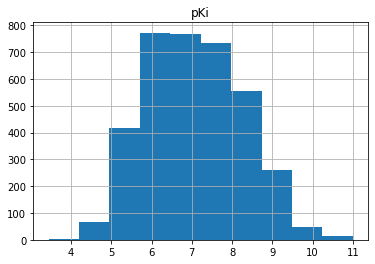

In [81]:
output_df.hist(column="pKi")

## Checking the molecules with highest pKi

In [84]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [85]:
# Sort molecules by pIC50
output_df.sort_values(by="pKi", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

,molecule_chembl_id,Ki,units,pKi,ROMol
0,CHEMBL1822945,0.010,nM,11.000000,
1,CHEMBL1822939,0.014,nM,10.853872,
2,CHEMBL1822944,0.020,nM,10.698970,

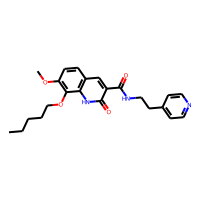
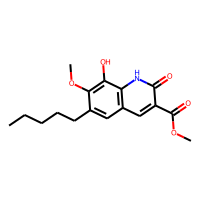
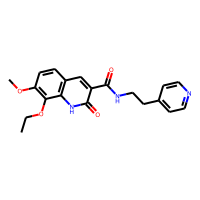

In [86]:
output_df.drop("smiles", axis=1).head(3)

## Preparing for Output

In [87]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (3641, 5)


In [92]:
output_df.to_csv(DATA / "CB2_compounds.csv")
output_df.head()

,molecule_chembl_id,Ki,units,smiles,pKi
0,CHEMBL1822945,0.010,nM,CCCCCOc1c(OC)ccc2cc(C(=O)NCCc3ccncc3)c(=O)[nH]c12,11.000000
1,CHEMBL1822939,0.014,nM,CCCCCc1cc2cc(C(=O)OC)c(=O)[nH]c2c(O)c1OC,10.853872
2,CHEMBL1822944,0.020,nM,CCOc1c(OC)ccc2cc(C(=O)NCCc3ccncc3)c(=O)[nH]c12,10.698970
3,CHEMBL3410832,0.021,nM,CCCCCOc1c(OC)ccc2cc(C(=O)NCCc3ccc(F)cc3)c(=O)n...,10.677781
4,CHEMBL1822940,0.021,nM,CCCOc1c(OC)ccc2cc(C(=O)NCCc3ccc(F)cc3)c(=O)[nH...,10.677781
